# Segmentation of cells

### Notes: 
#### path to data or other directories will be needed to change when running the notebook. I tried to document it as well as i could.
#### Author: Shay Guterman 
#### Contact information: shaygu62@gmail.com
#### Done at RSIP vision https://www.rsipvision.com/ seminar at the Hebrew University of Jerusalem #1 place solution.

## Installing tensorflow-gpu backend

In [0]:
!pip install tensorflow-gpu
# !pip install tensorboardcolab
print('Instalations completed!')

Instalations completed!


## Set up you google colab folder:
1. In your home googledrive golder create a folder named "RSIP_PRO_google_colab".
2. Download the file "RSIP_PRO_vanilla_net_seg_colab.ipynb" to this folder.
3. Download also the folder "class_2_data" to this folder. the folder class_2_data contains the training and validation data that you will work with.
4. Close the notebook and re-open it by double-clikking it from your own google drive account.

## Switch the colab session to GPU mode
#### Select from the menue-bar:  
Runtimes -->Reset all runtimes

Runtimes -->Change runtime type-->Hardwere accelerator-->GPU

## Mount your google drive to the colab session

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Importing libraries

In [0]:
from __future__ import print_function
############### Imports ######################################################################################
import os
import numpy as np
import tensorflow as tf
from skimage.io import imread, imsave
from skimage.color import rgba2rgb
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy.misc import imshow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Activation , BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam , RMSprop , Adadelta , Adamax , Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler, History
from tensorflow.keras import backend as K
import glob
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
# import tensorboardcolab 
# tbc = tensorboardcolab.TensorBoardColab()
##############################################################################################################
print('Imports completed')
print('tensorflow version:\t',tf.__version__)
import cv2



Imports completed
tensorflow version:	 1.13.1


## Checking GPU access

In [0]:
# Confirm TensorFlow can see the GPU
# (Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data parameters
###If the path to data is different please change it here!

In [0]:
############### TRAINING DATA CONSTANTS ######################################################################
# TODO: make sure to replace path_to_data_dir with your own path

# # # # # # # # # # Please Change this while running if needed # # # # # # # # # #
path_to_data_dir = "/content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/"
image_name = "img.png"
mask_name = "cumulativeMask.png"


##############################################################################################################
print('Defining parameters... Done!')

Defining parameters... Done!


## Defining data processing functions
###For the image:
>Change to BW in order to reduce complexity and memory\computation time

> Normalized each image by the max of the image

###For the mask:

> Mask is set to 0 and 1






In [0]:
def get_training_data(path_to_data_dir):
    """
    Find training and validation images in the given directory.
    :param path_to_data_dir: the absolute path to a data directory.
    :return:
            train_file_names: a list of training file names.
            val_file_names: a list of validation file names.
    """
    train_path = os.path.join(path_to_data_dir, "train")
    val_path = os.path.join(path_to_data_dir, "val")

    print("Trying to find training and validation data in folders:", train_path, val_path)

    train_file_names = glob.glob(train_path + "/*/" + image_name)
    val_file_names = glob.glob(val_path + "/*/" + image_name)

    # If this assert is reached, path_to_data_dir is probably wrong
    assert (len(train_file_names) > 0 and len(val_file_names) > 0)

    print("Found", len(train_file_names), "training files")
    print("Found", len(val_file_names), "validation files")

    return train_file_names, val_file_names

def load_image(path_to_image):
    """
    Loads png image from path_to_image to a numpy array.
    :param path_to_image: the absolute path to a png cell image.
    :return: a 3-dimensional numpy array of shape (height, width, 3) representing a RGB cell image.
    """
    img_array = imread(path_to_image)
    img_array_as_rgb = rgba2rgb(img_array).astype('float')

    return img_array_as_rgb


def preprocess_image(img_array):
    """
    Perform preprocessing of a cell image before feeding it to the model.
    :param img_array: a 3-dimensional numpy array of shape (height, width 3) representing a RGB cell image.
    :return: a processed version of the input image.
    """
    img_array = rgb2gray(img_array)
    img_array = img_array/np.max(np.max(np.max(img_array)))
#     img_array = img_array/np.mean(np.mean(np.mean(img_array)))
# 
#     img_array = img_array - 0.5
    img_array = np.expand_dims(img_array, axis=3)
    return img_array


def load_mask(path_to_mask):
    """
    Loads png binary mask from path_to_mask to a numpy array.
    :param path_to_mask: the absolute path to a png binary mask image.
    :return: a 2-dimensional numpy array of shape (height, width) representing a binary cell mask.
    """
    mask_array = imread(path_to_mask, as_gray=True)
    return mask_array

def preprocess_mask(mask_array):
    """
    Perform preprocessing of a binary mask before feeding it to the model.
    :param mask_array: a 2-dimensional numpy array of shape (height, width) representing a a binary cell mask.
    :return: a processed version of the input mask.
    """
    
    mask_array[mask_array > 0] = 1
    return mask_array

##############################################################################################################
print('Defining data processing functions:\nget_training_data(path_to_data_dir)\nload_image(path_to_image)\npreprocess_image(img_array)\nload_mask(path_to_mask)\npreprocess_mask(mask_array)')

Defining data processing functions:
get_training_data(path_to_data_dir)
load_image(path_to_image)
preprocess_image(img_array)
load_mask(path_to_mask)
preprocess_mask(mask_array)


## Defining function to read the data from the drive to the Disk
Reduces computational time while training

Uses the preprocess functions

In [0]:
############### DATA GENERATOR ###############################################################################
def data_reader(relevant_file_names):
    # This function is called twice: once for training and once for validation, and generates data for the model
    
    num_files = len(relevant_file_names)
#     print(num_files)
    images = []
    masks = []
    b = 0 
    for i in np.arange(num_files):
        # One iteration of the outer while loop == one epoch of the model.
        # The order of the files is randomized per epoch by the following line:
        # Go over list of files, feeding batch_size files to the model at a time
            # Obtain paths to single example + corresponding segmentation mask
          
            image_path = relevant_file_names[i]
            mask_path = image_path.replace(image_name, mask_name)

            # Load example + mask as numpy arrays:
            img_array = load_image(image_path)
            img_array = preprocess_image(img_array)
            mask_array = load_mask(mask_path)
            mask_array = preprocess_mask(mask_array)

            # For debugging purposes, show image + mask after loading
            # imshow(img_array)
            # imshow(mask_array)

            # Add channel to mask array (as required by Tensorflow, 'channels_last')
            # Image itself already has 3 channels so no expansion is required
            mask_array = mask_array[..., np.newaxis]

            # Add a batch dimension to both image and mask so that they can be concatenated along this axis:
            images.append(img_array)
            masks.append(mask_array)
#             img_array = np.expand_dims(img_array, axis=0)
#             mask_array = np.expand_dims(mask_array, axis=0)
            
#             if b == 0:
#                 # First example in batch
#                 batch_img = img_array
#                 batch_mask = mask_array
#             else:
#                 batch_img = np.concatenate((batch_img, img_array), axis=0)
#                 batch_mask = np.concatenate((batch_mask, mask_array), axis=0)
#             b = 1

    return (images, masks)

##############################################################################################################
print('im_reader is ready!')

im_reader is ready!


## Reading the data



In [0]:
print(path_to_data_dir)
training_data_file_names, validation_data_file_names = get_training_data(path_to_data_dir)
# test_data_file_names = get_testing_data(path_to_test_dir)

train_images,train_masks = data_reader(training_data_file_names)
val_images,val_masks = data_reader(validation_data_file_names)
# test_images,test_masks = data_reader(test_data_file_names)


print(('training images length',(len(train_images))))
print(('training mask length',len(train_masks)))
print(('validation images length',len(val_images)))
print(('validation masks length',len(val_masks)))

print(('train image shape',(train_images[0].shape)))
print(('train mask shape',(train_masks[0].shape)))
print(('val image shape',(val_images[0].shape)))
print(('val mask shape',(val_masks[0].shape)))

train_max_row = 3000;
train_max_col = 3000;
for i in np.arange(0,len(train_images)):
    image_row = train_images[i].shape[0]
    image_col = train_images[i].shape[1]
    if image_row < train_max_row:
      train_min_row = image_row
    if image_col < train_max_col:    
      train_min_col = image_col
      
print(['Training data minimum hight ',train_min_row])
print(['Training data minimum width ',train_min_col])

/content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/
Trying to find training and validation data in folders: /content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/train /content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/val
Found 575 training files
Found 95 validation files


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


('training images length', 575)
('training mask length', 575)
('validation images length', 95)
('validation masks length', 95)
('train image shape', (256, 256, 1))
('train mask shape', (256, 256, 1))
('val image shape', (256, 320, 1))
('val mask shape', (256, 320, 1))
['Training data minimum hight ', 256]
['Training data minimum width ', 256]


## Plotting some images and masks from the training set

For every two following images one is the image and the other is the mask. Image title is the mean of the image.



(256, 256, 1)


<Figure size 432x288 with 0 Axes>

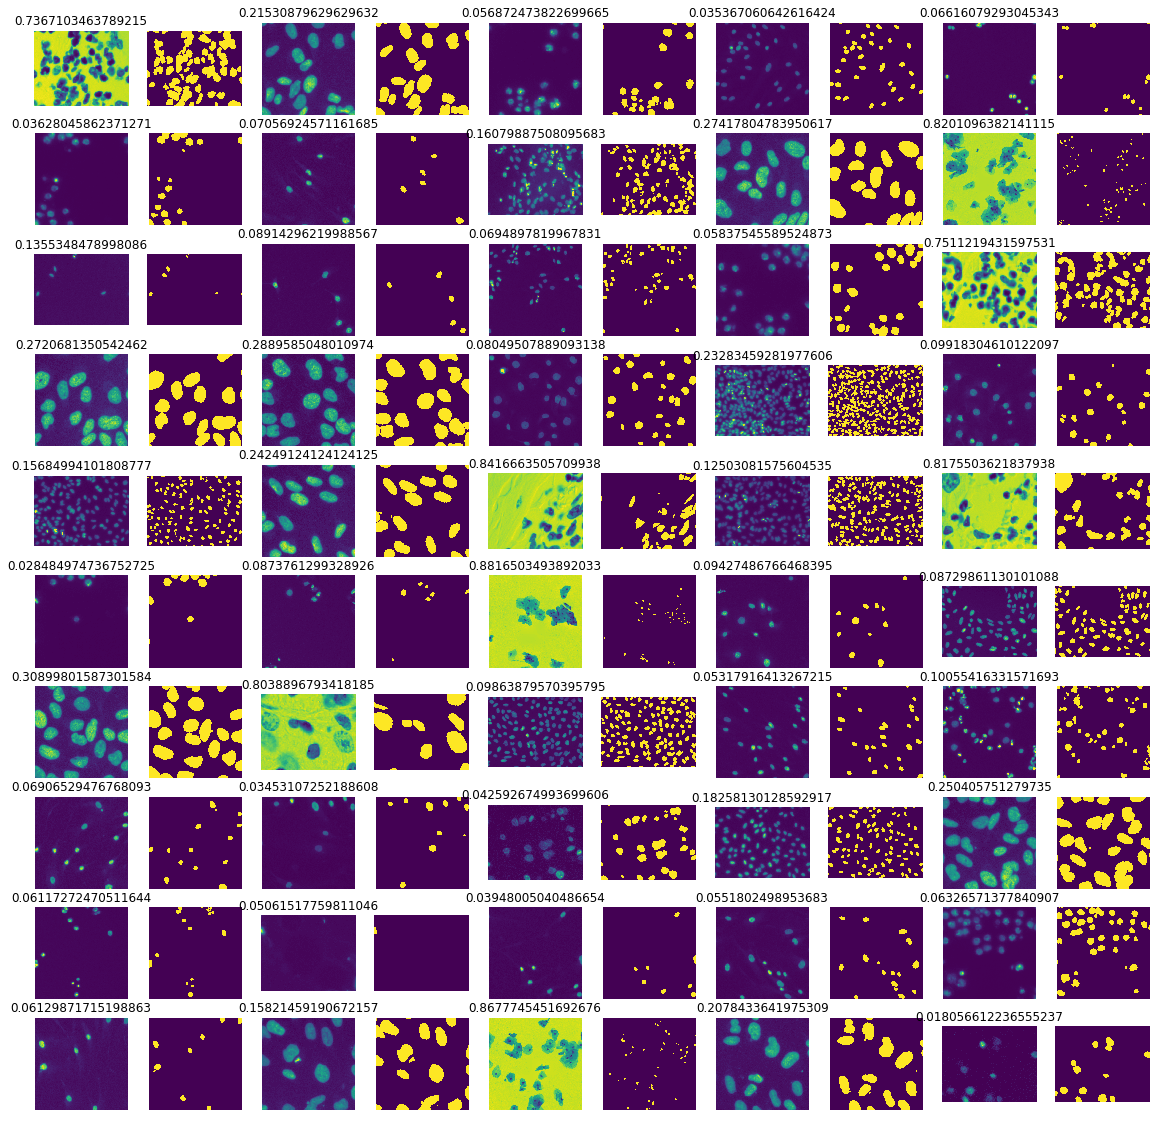

In [0]:
print(train_images[i].shape)

row_num = 10
col_num = 10
Images_num = row_num * col_num

plt.figure(0)
plt.figure(figsize=(col_num*2, row_num*2))


for i in np.arange(1,Images_num,2):
  plt.subplot(row_num, col_num, i)
  train_images_try = train_images[i][:,:,0]
#   train_images_try = train_images_try/np.mean(np.mean(train_images_try))
  plt.imshow(train_images_try)
  plt.axis('off')
#   plt.title(np.max(np.max(np.max(train_images_try))))
  plt.title(np.mean(np.mean(np.mean(train_images_try))))

  plt.subplot(row_num, col_num, i+1)
  plt.imshow(np.squeeze(train_masks[i]))
#   plt.title(np.max(np.max(np.max(train_masks[i]))))
#   plt.title(np.max(np.max(np.max(np.squeeze(train_masks[i])))))
  plt.axis('off')

  
 

## Defining random crop and plotting random cropped images

The image size will define the patches sizes the network will train validate and predict on.

> The larger the image size the more parameters the network will need

> The smaller the image size the less information each patch has

> In each image the title is the mean of the patch



<Figure size 432x288 with 0 Axes>

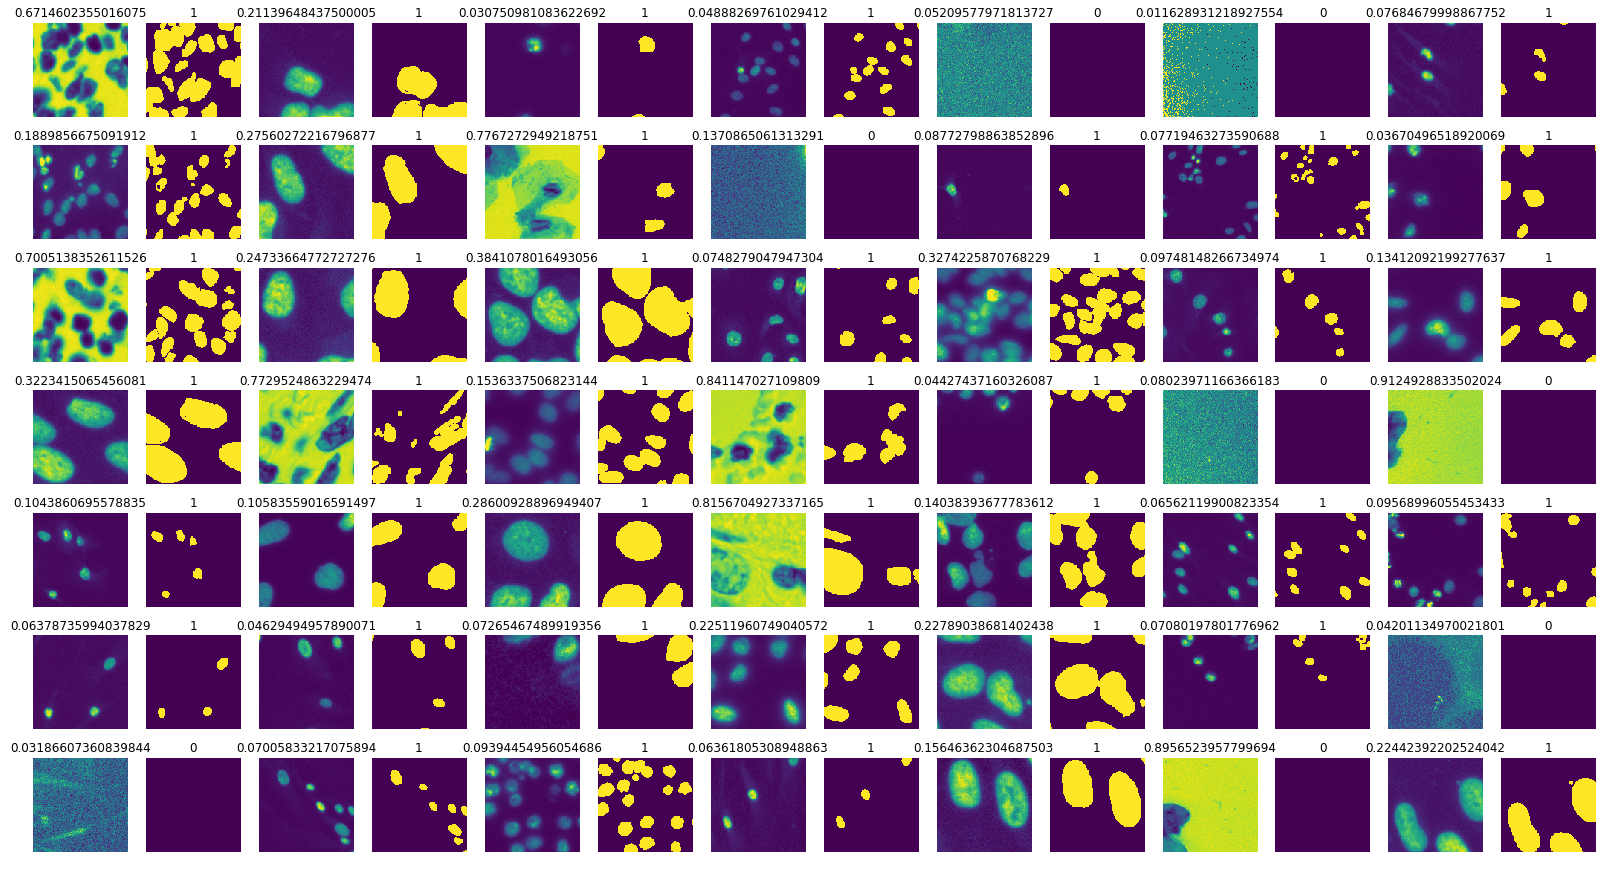

In [0]:
# Random crop gets imake mask and crop size - [image_width,image_hight]
# rangew and rangeh goes from image width/hight - crop_hight/width. For 256x256 image and 128/128 crop size we get a 128 - Lower left square
# offset w/h random number between 0 and range w/h
def random_crop(image,mask,crop_size):
    h, w, _  = image.shape
#     print(h,w)
    rangew = (w - crop_size[0]) // 1 if w>crop_size[0] else 0
    rangeh = (h - crop_size[1]) // 1 if h>crop_size[1] else 0
#     print(rangew,rangeh)
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
#     print(offsetw,offseth)
    cropped_x = image[offseth:offseth+crop_size[0], offsetw:offsetw+crop_size[1],:]
    cropped_y = mask[offseth:offseth+crop_size[0], offsetw:offsetw+crop_size[1],:]
    return cropped_x, cropped_y

image_num = 20
image_size = 128

row_num = 7
col_num = 14
Images_num = row_num * col_num

plt.figure(0)
plt.figure(figsize=(col_num*2, row_num*2.2))
for i in np.arange(1,Images_num,2):
  cropped_x,cropped_y = random_crop(train_images[i][:,:,:],train_masks[i][:,:,:],[image_size,image_size])
  plt.subplot(row_num, col_num, i)
#   train_images_try = train_images_try/np.mean(np.mean(train_images_try))
  plt.imshow(cropped_x[:,:,0])
  plt.axis('off')
  plt.title(np.mean(np.mean(np.mean(cropped_x[:,:,0]))))
  plt.subplot(row_num, col_num, i+1)
  plt.imshow(cropped_y[:,:,0])
  plt.title(np.max(np.max(np.max(cropped_y))))
#   plt.title(np.max(np.max(np.max(np.squeeze(train_masks[i])))))
  plt.axis('off')

  

## Batch generator function

After testing the model with some augmentation I came to the following conclusions.

> Predicting on an image with different size than the trained network size has a significant implications on the dice coefficent therefore the training and predicting on patches is important

> Patches size should be determined by looking at the random crop (and results obviously)

> The netowrk isnt able to overfit the data, therefore intreducing regularizations such as augmentations only hinders

> Dividing the data to randomly cropped patches increases the training and validation size significantly

> The validation is done on different patches everytime - introduces a undesired effect of validation on different patches each iteration



In [0]:
from skimage.color import rgb2gray
from imgaug import augmenters as iaa

############### DATA GENERATOR ###############################################################################
def generate_training_batches(images,masks, batch_size,image_height,image_width):
    # This function is called twice: once for training 
    # and once for validation and generates data for the model

    num_files = len(images)

    # -------- Data augmentation: define your augmentation methods -------------
    augmentation = iaa.Sequential(
        [
#             iaa.Fliplr(0.5),  # horizontally flip 50% of all images
#             iaa.Flipud(0.5),  # vertically flip 50% of all images
#             iaa.OneOf([iaa.Affine(rotate=90),
#                        iaa.Affine(rotate=180),
#                        iaa.Affine(rotate=270)])
        ], random_order=True)
    
    # --------------------------------------------------------------------------

    while True:
        # One iteration of the outer while loop == one epoch of the model.
        # The order of the files is randomized per epoch by the following line:
        random_index_order = np.random.permutation(num_files)
        # Go over list of files, feeding batch_size files to the model at a time
        for batch_index in range(0, num_files - batch_size + 1, batch_size):
            for b in range(0, batch_size):
                cur_ind = random_index_order[batch_index + b]
                # Obtain paths to single example + corresponding segmentation mask
                image = images[cur_ind]
                mask  = masks[cur_ind] 
                image , mask = random_crop(image,mask,[image_height,image_width])

                # Add dimensions to both image and mask so that they can be concatenated along this axis:
                img_array = np.expand_dims(image, axis=0)
                mask_array = np.expand_dims(mask, axis=0)
#                 mask_array[mask_array > 0] = 1500
                if b == 0:
                    # First example in batch
                    batch_img = img_array
                    batch_mask = mask_array
                else:
                    batch_img = np.concatenate((batch_img, img_array), axis=0)
                    batch_mask = np.concatenate((batch_mask, mask_array), axis=0)
                 
                
            # ------------ Apply the augmentation for the bach -----------------
#             print(' Performing augmentation for the batch... ') # print for debugging
            aug_det = augmentation.to_deterministic()
            batch_img = aug_det.augment_images(batch_img)
            batch_mask = aug_det.augment_images(batch_mask)
            # ------------------------------------------------------------------
            
            
            yield (batch_img, batch_mask)
            batch_img = None
            batch_mask = None


##############################################################################################################
print('Defining the batch generator with basic image augmentation... Done!')



# generate_training_batches(val_images,val_masks, batch_size , image_height , image_width)

# print(batch_img.shape)
# print(batch_mask.shape)

Defining the batch generator with basic image augmentation... Done!


## Optional - change the generator and plot the augmentations

In [0]:
batch_size = 64
image_height = 128
image_width = 128

(batch_img, batch_mask) = generate_training_batches(val_images,val_masks, batch_size , image_height , image_width)
print(batch_img.shape)
print(batch_mask.shape)

row_num = 8
col_num = 8
Images_num = row_num * col_num
plt.figure(0)
plt.figure(figsize=(col_num*2, row_num*2))


for i in np.arange(1,Images_num,2):
  plt.subplot(row_num, col_num, i)
  train_images_try = batch_img[i,:,:,0]
#   train_images_try = train_images_try/np.mean(np.mean(train_images_try))
  plt.imshow(train_images_try)
#   plt.axis('off')
  plt.title(np.max(np.max(np.max(train_images_try))))
  plt.subplot(row_num, col_num, i+1)
  plt.imshow(np.squeeze(batch_mask[i,:,:,0]))
  plt.title(np.max(np.max(np.max(batch_mask[i,:,:,:]))))
#   plt.axis('off')

ValueError: ignored

## Define the loss and performance metric

To watch - the dice coef is defined that if i normalized the mask (predicted or true) to values other than 1 the dice coefficent and therefore the loss isnt bounded between 0 and 1. 

In [0]:
############### METRICS AND TRAINING LOSS ####################################################################
def dice_coef(y_true, y_pred):
    # calculating the DICE coefficient with a smoothing term
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    smooth = 1

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    # calculating the DICE loss function for GD
    return 1 - dice_coef(y_true, y_pred)


#############################################################################################################
print('Performance metric:\tDice coefficient\nLoss function:\t\t1 - Dice')

Performance metric:	Dice coefficient
Loss function:		1 - Dice


## Define the U-Net architecture

I added batch normalization because it worked better.

I added dropout for regularization but when i decided i dont need regularization i removed it.

In [0]:
################## MODEL ARCHITECTURE DEFINITION ############################################################


#
###### FUNCTIONS DEFINING U-NET BLOCKS ######
def convolution_block(input_layer, num_filters, kernel_size, activation_func):
    conv1 = Conv2D(filters=num_filters, kernel_size=kernel_size,
                   kernel_initializer='he_uniform', padding='same')(input_layer)
    BN = BatchNormalization()(conv1)
    conv1Activated = Activation('relu')(BN)
#     Drop = Dropout (0.001)(conv1Activated)
    conv2 = Conv2D(filters=num_filters, kernel_size=kernel_size,
                   kernel_initializer='he_uniform', padding='same')(BN)
    BN2 = BatchNormalization()(conv2)
    conv2Activated = Activation('relu')(BN2)
#     Drop2 = Dropout (0.2)(conv2Activated)
    return conv2Activated


def conv_downsample_block(input_layer, num_filters, kernel_size, activation_func, max_pool_shape):
    pool = MaxPooling2D(pool_size=max_pool_shape)(input_layer)
    
    conv_block = convolution_block(pool, num_filters, kernel_size, activation_func)

    return conv_block


def conv_upsample_block(input_layer, skip_connection_layer, num_filters, kernel_size, activation_func,
                        upsampling_shape):
    upsampling = UpSampling2D(size=upsampling_shape)(input_layer)
    concatenate_skip = concatenate([upsampling, skip_connection_layer], axis=3)
    conv_block = convolution_block(concatenate_skip, num_filters, kernel_size, activation_func)

    return conv_block


###### U-NET ARCHITECTURE ######
def get_unet(img_rows, img_cols, first_layer_num_filters=32, num_classes=1):
    inputs = Input((img_rows, img_cols, 1))

    ###### ENCODER BRANCH ######
    first_conv_block = convolution_block(input_layer=inputs,
                                         num_filters=first_layer_num_filters,
                                         kernel_size=(3, 3),
                                         activation_func="relu")
    conv_ds_block_1 = conv_downsample_block(input_layer=first_conv_block,
                                            num_filters=first_layer_num_filters * 2,
                                            kernel_size=(3, 3),
                                            activation_func="relu", max_pool_shape=(2, 2))
    conv_ds_block_2 = conv_downsample_block(input_layer=conv_ds_block_1,
                                            num_filters=first_layer_num_filters * 4,
                                            kernel_size=(3, 3),
                                            activation_func="relu", max_pool_shape=(2, 2))
    conv_ds_block_3 = conv_downsample_block(input_layer=conv_ds_block_2,
                                            num_filters=first_layer_num_filters * 8,
                                            kernel_size=(3, 3),
                                            activation_func="relu", max_pool_shape=(2, 2))

    ##### BOTTOM OF U-SHAPE #####
    bottom_conv_block = conv_downsample_block(input_layer=conv_ds_block_3,
                                              num_filters=first_layer_num_filters * 16,
                                              kernel_size=(3, 3),
                                              activation_func="relu", max_pool_shape=(2, 2))

    ###### DECODER BRANCH ######
    conv_us_block_1 = conv_upsample_block(input_layer=bottom_conv_block, skip_connection_layer=conv_ds_block_3,
                                          num_filters=first_layer_num_filters * 8,
                                          kernel_size=(3, 3),
                                          activation_func="relu", upsampling_shape=(2, 2))
    conv_us_block_2 = conv_upsample_block(input_layer=conv_us_block_1, skip_connection_layer=conv_ds_block_2,
                                          num_filters=first_layer_num_filters * 4,
                                          kernel_size=(3, 3),
                                          activation_func="relu", upsampling_shape=(2, 2))
    conv_us_block_3 = conv_upsample_block(input_layer=conv_us_block_2, skip_connection_layer=conv_ds_block_1,
                                          num_filters=first_layer_num_filters * 2,
                                          kernel_size=(3, 3),
                                          activation_func="relu", upsampling_shape=(2, 2))
    last_conv_block = conv_upsample_block(input_layer=conv_us_block_3, skip_connection_layer=first_conv_block,
                                          num_filters=first_layer_num_filters,
                                          kernel_size=(3, 3),
                                          activation_func="relu", upsampling_shape=(2, 2))

    output_layer = Conv2D(num_classes, (1, 1), activation='sigmoid')(last_conv_block)

    model = Model(inputs=[inputs], outputs=[output_layer])

#     model.summary()

    return model
  
#############################################################################################################
# tmp_model = get_unet(None, None, 32, 1)

## Function to evaluate model preformance

In [0]:
def plot_model_performance(model_history):

    train_loss = model_history.history['loss']
    train_acc = model_history.history['acc']  
    train_val_loss = model_history.history['val_loss']
    train_val_acc = model_history.history ['val_acc']
    green = '#72C29B'
    orange = '#FFA577'

    # plt.xkcd()
    # plot model loss
    fig, ax1 = plt.subplots()
    ax1.plot(range(1, len(train_loss) + 1), train_loss, green, linewidth=3,
             label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, orange, linewidth=3, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    # plot model accuracy
    fig, ax2 = plt.subplots()
    ax2.plot(range(1, len(train_acc) + 1), train_acc, green, linewidth=3, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, orange,
             linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)

## Model training function

### Saving best iterations at path_to_dir

### path_to_dir might need to be redefined

### Parameters for the network:
> 32 filters to capture as much complexity as possible in google colab

> Image height and width discussed earlier

### Parameters for training

> batch size = 64 to estimate the gradient the best, more than that takes to much memory

> Large amount of steps per epoch - compensate for training on random batches that are very different from each other. 



Epoch 1/175
7/7 [==============================] - 2s 342ms/step - loss: 0.9042 - acc: 0.8361 - dice_coef: 0.0958

Epoch 00001: val_loss improved from inf to 0.90415, saving model to /content/gdrive/My Drive/RSIP_PRO_google_colab/best_weights.hdf5
55/55 [==============================] - 54s 975ms/step - loss: 0.3228 - acc: 0.8848 - dice_coef: 0.6772 - val_loss: 0.9042 - val_acc: 0.8361 - val_dice_coef: 0.0958
Epoch 2/175
7/7 [==============================] - 1s 144ms/step - loss: 0.7535 - acc: 0.1429 - dice_coef: 0.2465

Epoch 00002: val_loss improved from 0.90415 to 0.75351, saving model to /content/gdrive/My Drive/RSIP_PRO_google_colab/best_weights.hdf5
55/55 [==============================] - 26s 470ms/step - loss: 0.1655 - acc: 0.9532 - dice_coef: 0.8345 - val_loss: 0.7535 - val_acc: 0.1429 - val_dice_coef: 0.2465
Epoch 3/175
7/7 [==============================] - 1s 147ms/step - loss: 0.6433 - acc: 0.5036 - dice_coef: 0.3567

Epoch 00003: val_loss improved from 0.75351 to 0.6433

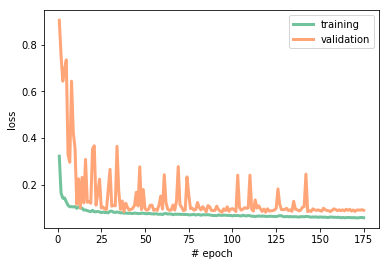

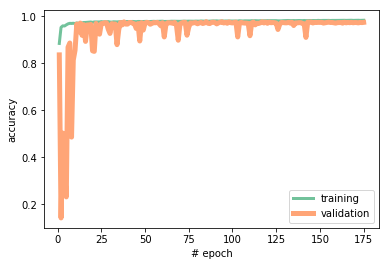

In [0]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.optimizers import Adam ,RMSprop

# lr = 1e-1 batch = 32 epoch = 50 for 90%

# 2 pm
lr=1e-2
lr_decay=0.0008

# lr=1e-2
# lr_decay=0.0008
# 75 epochs = 35 minutes
# Avg Dice score: 0.9088507434639042
# Avg Dice score: 0.9033269706619189
# 9051 for end vs 9014 for best (around epoch 75)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_dice_coef', 
                                            patience=35, 
                                            verbose=1, 
                                            factor=0.6, 
                                            min_lr=0.0001)
# 9 and 60 epochs for 90%


batch_size = 64
image_height = 128
image_width = 128

train_generator = generate_training_batches(train_images,train_masks, batch_size , image_height , image_width)
valid_generator = generate_training_batches(val_images,val_masks, batch_size , image_height , image_width)



# # # # # # # # # # Please Change this while running if needed # # # # # # # # # #
path_to_dir = "/content/gdrive/My Drive/RSIP_PRO_google_colab/"
filepath= path_to_dir + "best_weights.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


epochs = 175
filters_num = 32
model = get_unet(image_height,image_width,first_layer_num_filters=filters_num, num_classes=1)
model.compile(optimizer=Adam(lr=lr, decay=lr_decay), loss=dice_coef_loss, metrics=['accuracy', dice_coef])
# model.compile(optimizer=Adam(lr=lr, decay=lr_decay, beta_1=0.9, beta_2=0.999), loss=dice_coef_loss, metrics=['accuracy', dice_coef])



history = model.fit_generator(train_generator,
                              epochs = epochs, validation_data=valid_generator,
                              verbose = 1, steps_per_epoch= 55 , validation_steps = 5 * len(val_images) // batch_size,callbacks=[checkpoint])
plot_model_performance(history)



## Model evaluation

In [0]:
################## DISPLAYING MODEL RESULTS ##################################################################
def postprocess_segmentation(segmentation_prediction):
    segmentation_prediction[segmentation_prediction >= 0.5] = 1
    segmentation_prediction[segmentation_prediction < 0.5] = 0

    return segmentation_prediction


def predict_using_patches(processed_img, trained_model, patch_rows=image_height,
                          patch_cols=image_width):
    """
    Predicts a segmentation for a single image using patch-based method.
    The input image is cropped into patches, these patches are fed into the segmentation model,
    and resulting predictions are stitched back together to make a final segmentation mask.
    :param processed_img: a processed input image (after calling preprocess_image)
    :param trained_model: a trained segmentation model
    :param patch_rows: number of rows in a patch
    :param patch_cols: number of cols in a patch
    :return: a 2-dimensional numpy array representing processed_img's cell segmentation.
    """
    img_rows, img_cols, img_channels = processed_img.shape
    segmentation_prediction = np.zeros((img_rows, img_cols))

    # loop over image and crop patches of size (patch_rows, patch_cols)
    for i in range(0, img_rows, patch_rows):
        i = max(min(i, img_rows - patch_rows - 1), 0)
        for j in range(0, img_cols, patch_cols):
            j = max(min(j, img_cols - patch_cols - 1), 0)
            img_patch = np.copy(processed_img[i:i + patch_rows, j:j + patch_cols, :])
            img_patch = np.expand_dims(img_patch, 0)
            # save segmentation result into final mask
            segmentation_prediction[i:i + patch_rows, j:j + patch_cols] = np.squeeze(trained_model.predict(img_patch))

    return segmentation_prediction


def predict_single_image(path_to_image, trained_model, display_result=True):
    """
    Predict a cell segmentation for a single image.
    :param path_to_image: the absolute path to a cell png image.
    :param trained_model: a trained model to be used for prediction.
    :param display_result: a boolean flag indicating whether results should be displayed after prediction.
    :return: a 2-dimensional numpy array of shape (height, width) representing img_array's cell segmentation.
    """
    img_array = load_image(path_to_image)
    processed_img = preprocess_image(img_array)

    segmentation_prediction = predict_using_patches(processed_img, trained_model)
    processed_segmentation = postprocess_segmentation(segmentation_prediction)

    if display_result:
        imshow(img_array)
        imshow(processed_segmentation)
    return processed_segmentation


def dice_coef_for_np_array(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    smooth = 1

    intersection_size = np.sum(y_true_flat * y_pred_flat)
    dice_score = (2. * intersection_size + smooth) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + smooth)

    return dice_score




  


## End Model evaluation Shay

For making sense of the network, each three consecutive images consists of the image, my prediction and the true prediction. The title of the middle image is the dice coefficent between the predicted and the true image.

The test is done on the network finished training

The data is taken from validation

0.9016110338246364


<Figure size 432x288 with 0 Axes>

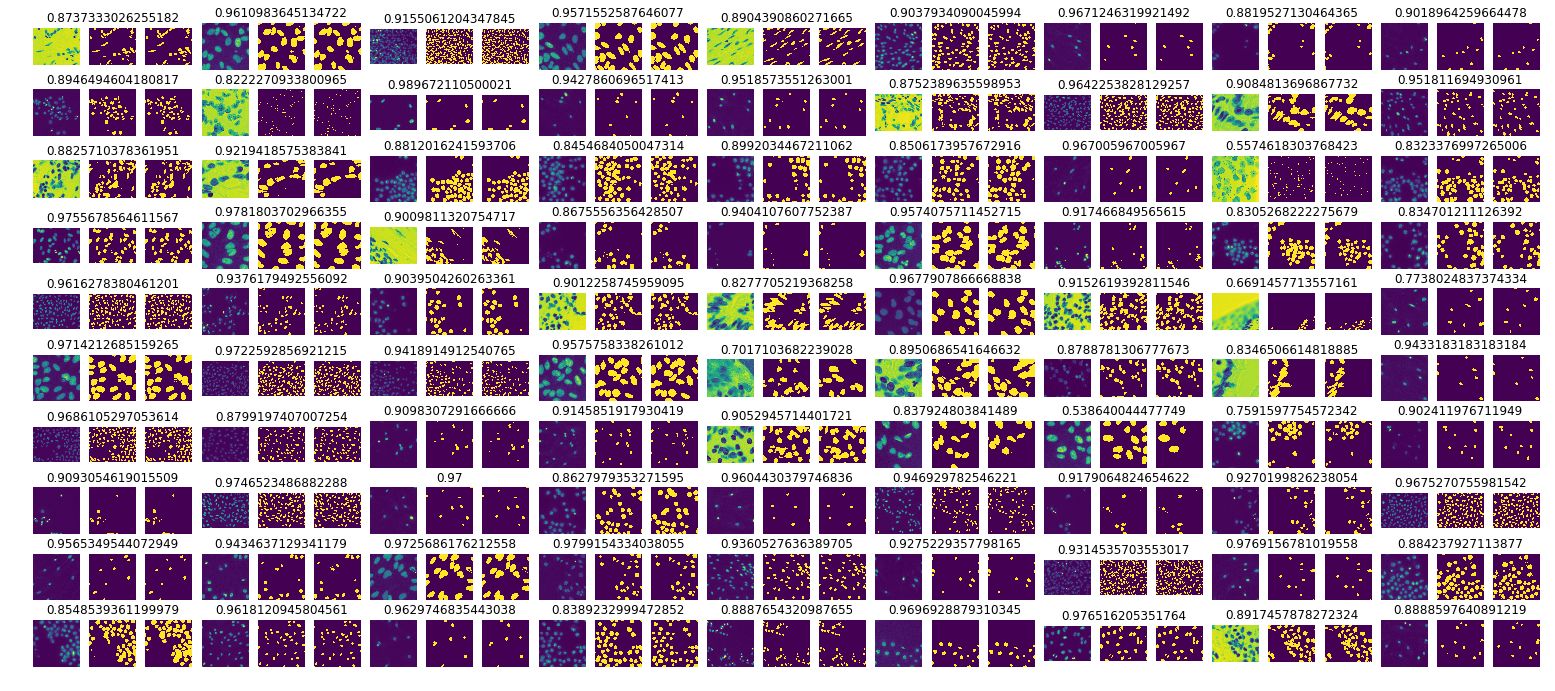

In [0]:
row_num = 10
col_num = 9 * 3
plt.figure(0)
plt.figure(figsize=(col_num , row_num *1.2))
Images_num = row_num*col_num
end_dice_score = 0
for i in np.arange(0,int((Images_num/3)),1):

  image_array = val_images[i]
  segmentation_prediction = predict_using_patches(image_array, model)
  processed_segmentation = postprocess_segmentation(segmentation_prediction)
  mask_array = val_masks[i]
  curr_dice_score = dice_coef_for_np_array(mask_array, segmentation_prediction)
  end_dice_score += curr_dice_score   
   
  plt.subplot(row_num, col_num, i*3+1)
  plt.imshow(image_array[:,:,0])
  plt.axis('off')
  plt.subplot(row_num, col_num, i*3+2)
  plt.imshow(np.squeeze(processed_segmentation[:,:]))
  plt.title(curr_dice_score)
  plt.axis('off')
  plt.subplot(row_num, col_num, i*3+3)
  plt.imshow(np.squeeze(mask_array[:,:,0]))
  plt.axis('off')
end_dice_score /= Images_num/3
print(end_dice_score)



## Best Model evaluation Shay

For making sense of the network, each three consecutive images consists of the image, my prediction and the true prediction. The title of the middle image is the dice coefficent between the predicted and the true image.

The test is done on the best iteration of the network

The data is taken from validation

0.9003314396235488


<Figure size 432x288 with 0 Axes>

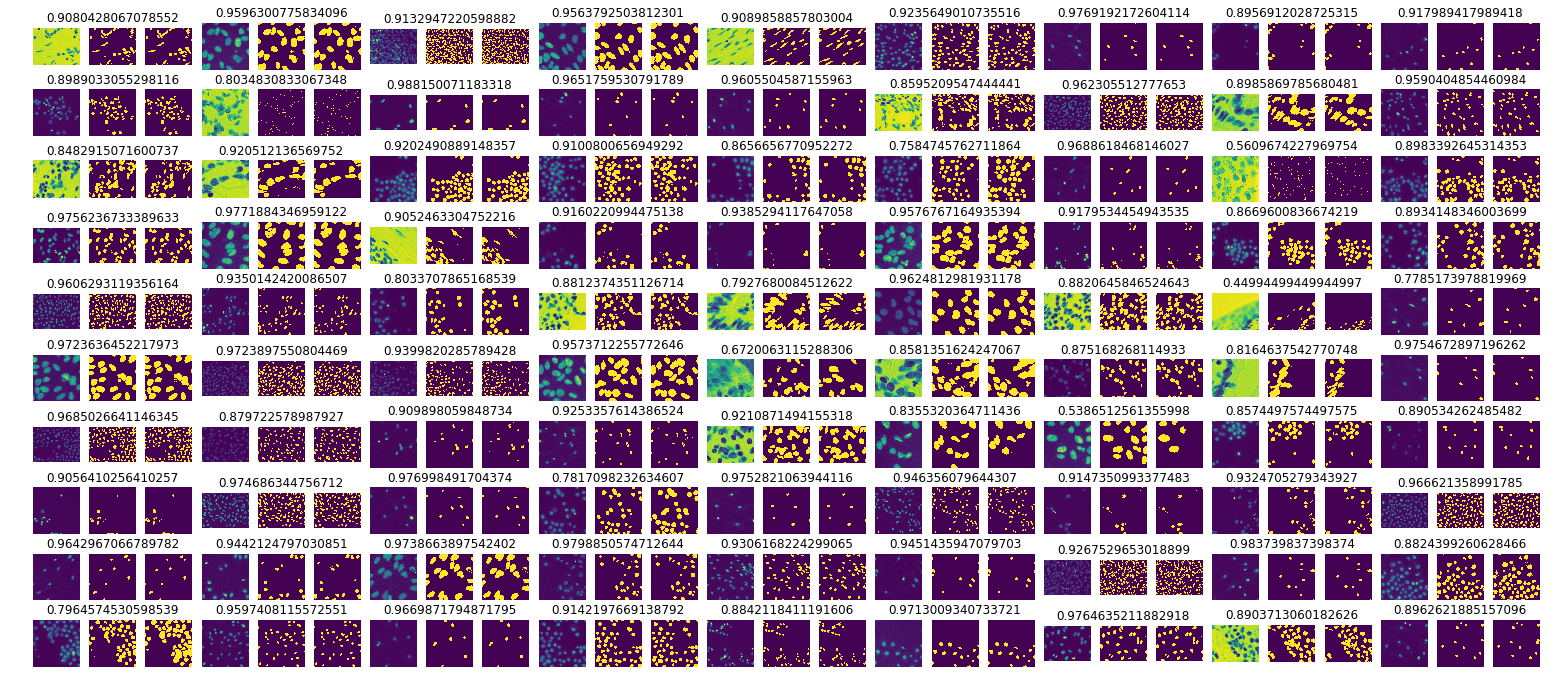

In [0]:
best_model = get_unet(None, None, 32, 1)
# path = '/content/gdrive/My Drive/RSIP_junk/saved netsweights-improvement-74-0.09.hdf5'
# path = '/content/gdrive/My Drive/RSIP_PRO_google_colab/best_weights.h5'
best_model.load_weights(path_to_dir +"best_weights.hdf5") 

row_num = 10
col_num = 9 * 3
plt.figure(0)
plt.figure(figsize=(col_num , row_num *1.2))
Images_num = row_num*col_num
best_dice_score = 0
for i in np.arange(0,int((Images_num/3)),1):
  image_array = val_images[i]
  segmentation_prediction = predict_using_patches(image_array, best_model)
  processed_segmentation = postprocess_segmentation(segmentation_prediction)
  mask_array = val_masks[i]
  curr_dice_score = dice_coef_for_np_array(mask_array, segmentation_prediction)
  best_dice_score += curr_dice_score   
   
  plt.subplot(row_num, col_num, i*3+1)
  plt.imshow(image_array[:,:,0])
  plt.axis('off')
  plt.subplot(row_num, col_num, i*3+2)
  plt.imshow(np.squeeze(processed_segmentation[:,:]))
  plt.title(curr_dice_score)
  plt.axis('off')
  plt.subplot(row_num, col_num, i*3+3)
  plt.imshow(np.squeeze(mask_array[:,:,0]))
  plt.axis('off')
best_dice_score /= Images_num/3
print(best_dice_score)



## Final evaluation

#### Change path to val!!


In [0]:
def evaluate_model(path_to_folder, trained_model):
    """
    Predicts a cell segmentation for all images within a given folder (for example, the "val" folder).
    Each segmentation prediction will be save along its input image under the name "segmentationPrediction.png".
    In addition, an average dice score will be calculated over the given data set.
    :param path_to_folder: the absolute path to a folder containing cell png images, in the same structure as
            the "train" and "val" folders.
    :param trained_model: The choosen model.
    :return: a floating number, representing the average dice score over the given data set.
    """
    # load trained model
    path_to_weights = 'predicted'
    image_name = 'img.png'
    # predict segmentation for all images in given folder
    average_dice_score = 0
    all_images_in_folder = glob.glob(path_to_folder + "/*/" + image_name)
    total_num_images = len(all_images_in_folder)
    print(total_num_images)
    for path_to_image in all_images_in_folder:
        print("Predicting segmentation for:", path_to_image)

        segmentation_prediction = predict_single_image(path_to_image, trained_model, display_result=False)

        save_path = os.path.join(os.path.dirname(path_to_image),
                                 os.path.basename(path_to_weights) + "_segmentationPrediction.png")
#         imsave(save_path, segmentation_prediction)

        path_to_mask = path_to_image.replace(image_name, mask_name)
        mask_array = preprocess_mask(load_mask(path_to_mask))
        curr_dice_score = dice_coef_for_np_array(mask_array, segmentation_prediction)
        average_dice_score += curr_dice_score
        print("Dice score:", curr_dice_score)


    average_dice_score /= total_num_images
    print("Avg Dice score:", average_dice_score)

    return average_dice_score



# path_to_test = ??

path_to_val = '/content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/val'


if end_dice_score >= best_dice_score:
  evaluate_model(path_to_val, model)
else:
  evaluate_model(path_to_val, best_model)





95
Predicting segmentation for: /content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/val/136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261/img.png
Dice score: 0.8737333026255182
Predicting segmentation for: /content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/val/0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275/img.png


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Dice score: 0.9610983645134722
Predicting segmentation for: /content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/val/07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5/img.png
Dice score: 0.9155061204347845
Predicting segmentation for: /content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/val/06c779330d6d3447be21df2b9f05d1088f5b3b50dc48724fc130b1fd2896a68c/img.png
Dice score: 0.9571552587646077
Predicting segmentation for: /content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/val/0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6/img.png
Dice score: 0.8904390860271665
Predicting segmentation for: /content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/val/04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e/img.png
Dice score: 0.9037934090045994
Predicting segmentation for: /content/gdrive/My Drive/RSIP_PRO_google_colab/class2_data/val/077f026f4ab0f0bcc0856644d99cbf639e443ec4f067d7b708bc6cecac609424/img.png
Dice score: 0.967124